In [2]:
import pickle
import geoplot
import numpy as np
import itertools
import geopandas as gpd
import mapclassify as mc
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import defaultdict

import GeoDataProcessing.dispatchAnalysis as DA

In [9]:
with open('StatisticsResults/friday_0_survival_preparedness_Relocate_Workload_0.4_NoUber.pickle', 'rb') as f:
    statistics = pickle.load(f)

In [452]:
def mapGraphNodesDataToUniformDemand(data, demand_nodes, city_nodes_df, agg='sum', default=1, value_col='value'):
    """
    With an iterable of tuples (pos, value), return a geodataframe with geometry of uniform demand nodes
    and aggregated values
    """
    data_dict = defaultdict(list)
    for d in data:
        data_dict[d[0]].append(d[1])
    data_list = [(k, v) for k, v in data_dict.items()]
    positions = [d[0] for d in data_list]
    
    new_df = demand_nodes.copy()
    new_df[value_col] = default
    
    city_nodes_df.index = city_nodes_df['osmid']

    nearest_indexes = DA.nearest_neighbor(city_nodes_df.loc[positions,:], demand_nodes, index = True)[0]

    demand_dict = defaultdict(list)
    for i, index in enumerate(nearest_indexes):
        demand_dict[index] += data_list[i][1]
    demand_list = [(k, v) for k, v in demand_dict.items()]
    positions = [d[0] for d in demand_list]
    
    new_df.index = range(len(new_df))

    if agg == 'sum':
        new_df.loc[positions, value_col] = [np.sum(d[1]) for d in demand_list]
    elif agg == 'avg':
        new_df.loc[positions, value_col] = [np.mean(d[1]) for d in demand_list]
    elif agg == 'min':
        new_df.loc[positions, value_col] = [np.min(d[1]) for d in demand_list]
    elif agg == 'max':
        new_df.loc[positions, value_col] = [np.max(d[1]) for d in demand_list]
    else:
        raise ValueError('Aggregate type not understood')

    return new_df

In [188]:
def visualizeSpatialStatistic(ax, area_shp, data, points_from_map, points_to_map, agg='avg', default=0, method='quadtree', quantile_clip=1, **kwargs):
    """
    data is expected to be a list of tuples with form (time, pos, value)
    """
    geoplot.polyplot(area_shp.simplify(0.001), ax = ax)
    points = mapGraphNodesDataToUniformDemand([(d[1], d[2]) for d in data], points_to_map, points_from_map, agg=agg, default=default)

    if quantile_clip < 1:
        points['value'] = points['value'].clip(0, points['value'].quantile(quantile_clip))
    
    if method == 'quadtree':
        geoplot.quadtree(points, clip=area_shp, nmax=1,
                         hue='value', edgecolor='white', ax=ax, **kwargs)
    
    elif method == 'points':
        geoplot.pointplot(points, hue='value', ax=ax, **kwargs)
    
    else:
        raise('Method not understood.')

In [ ]:
def computeAmbulanceUtilization(statistics, sim_time=24*3600):
    

In [476]:
def visualizeStateStatisticData(data, show_mean=False):
    x = []
    y = []
    for i in range(len(data) - 1):
        if data[i][0] != data[i+1][0]:
            x.append(data[i][0])
            x.append(data[i+1][0])
            y.append(data[i][1])
            y.append(data[i][1])
    plt.plot(x, y, '-')
    
    if show_mean:
        plt.plot([0, data[-1][0]], [average()]*2, 'r-')
    
    plt.title('StateStatistic over time')
    plt.show()

In [432]:
# Load the boundaries to be drawn
DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/ems-ny-data/'
nyc_boundaries = gpd.read_file(DATA_DIR + 'Generated Shapefiles/NYC Subdivisions/Borough Boundaries/Borough Boundaries.shp')
demand_points = gpd.read_file(DATA_DIR + 'Generated Shapefiles/GeoTools/Uniform1km/Uniform1kmDemand.shp')
candidate_points = gpd.read_file(DATA_DIR + 'NYC Graph/EMScandidatesMixedLR.geojson')
nyc_graph_nodes = gpd.read_file(DATA_DIR + 'NYC Graph/NYC_nodes_revised.geojson')

#fig, axs = plt.subplots(1,1, figsize=(20,10))

#scheme = mc.Quantiles(points['value'], k=10)
#fig.colorbar(cm.ScalarMappable(colors.Normalize(vmin=points['value'].min(), vmax=points['value'].max()), cmap='Reds'))

#results = []

#with open('StatisticsResults/friday_0_survival_preparedness_Relocate_Workload_0.4_NoUber.pickle', 'rb') as f:
#    statistics = pickle.load(f)
#    results.append(statistics)

#with open('StatisticsResults/friday_0_survival_nearest_Relocate_Workload_0.4_NoUber.pickle', 'rb') as f:
#    statistics = pickle.load(f)
#    results.append(statistics)

#values = []

#for r, statistics in enumerate(results):
#    visualizeSpatialStatistic(axs, nyc_boundaries, statistics[0]['SpatialHS8minCover'].data, nyc_graph_nodes, demand_points, quantile_clip=.95, default=1, cmap=plt.cm.get_cmap('Reds').reversed())

#visualizeSpatialStatistic(axs[0], nyc_boundaries, statistics[0]['SpatialHSAverageResponseTime'].data, nyc_graph_nodes, demand_points)
#fig.colorbar(cm.ScalarMappable(colors.Normalize(vmin=0, vmax=1), cmap=plt.cm.get_cmap('Reds').reversed()))    

In [35]:
def extractStatistics(relocator = 'coverage', dispatcher='nearest', relocate = True, workload = True, workload_limit = 0.4, uber= False, ambulance_config='LowAmbulances', gap = 0.05, day = 'friday', replica = 0, parameters_dir='HRDemand'):

    name = '{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}'.format(day, replica, relocator, dispatcher,
                                            'Relocate' if relocate else 'NoRelocation', 'Workload' if workload else 'NoWorkloadRestriction',
                                            workload_limit, 'Uber' if uber else 'NoUber', gap, parameters_dir, ambulance_config)

    with open('StatisticsResults/{}.pickle'.format(name), 'rb') as f:
        statistics = pickle.load(f)

    return [relocator, dispatcher, relocate, workload, workload_limit, uber, ambulance_config, gap, day, replica, parameters_dir, statistics[0]['EmergenciesServed'].data,
            statistics[0]['EmergenciesTimeInSystem'].average(), statistics[0]['HSresponseTime'].average(), statistics[0]['LSresponseTime'].average(),
            statistics[0]['PercentageALSlt10min'].data[-1][1], statistics[0]['PercentageALSlt8min'].data[-1][1], statistics[0]['PercentageALSlt7min'].data[-1][1],
            len(statistics[0]['UberCalls'].data), statistics[0]['UberResponseTime'].average() ,statistics[0]['EmergenciesWaiting'].average()]

In [36]:
rel = ['coverage', 'survivalNpExp']
dispa = ['nearest', 'preparedness']
relocate = [True, False]

for element in itertools.product([1, 2, 3], ['a', 'b'], [4, 5])

['coverage',
 'nearest',
 True,
 True,
 0.4,
 False,
 'LowAmbulances',
 0.05,
 'friday',
 0,
 'HRDemand',
 3466,
 1573.3787037282293,
 294.72071754163653,
 212.55242278211364,
 0.9257182901191309,
 0.8444288717589353,
 0.7785564120532595,
 0,
 0,
 11.90508856170886]

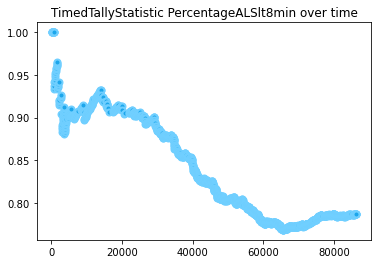

In [7]:
#fig, ax = plt.subplots(1,1, figsize=(15,15))

with open('StatisticsResults/friday_0_coverage_nearest_NoRelocation_Workload_0.4_NoUber_0.05.pickle', 'rb') as f:
    statistics = pickle.load(f)
    
#statistics[0]['TravelTime'].average(),np.std([d[1] for d in statistics[0]['TravelTime'].data])

#visualizeSpatialStatistic(ax, nyc_boundaries, statistics[0]['SpatialALSRelocation'].data, nyc_graph_nodes, candidate_points, quantile_clip=1, default=0, method='points', legend=True)
#plt.hist([d[1] for d in statistics[0]['HSresponseTime'].data], bins=100)
#statistics[1]['Ambulance 57']['Statistics']['State'].visualize()
statistics[0]['PercentageALSlt8min'].visualize()
#statistics[0]['GAPALSPart1'].visualize()

#visualizeStateStatisticData(statistics[0]['AvailableALSVehicles'].data[1:])

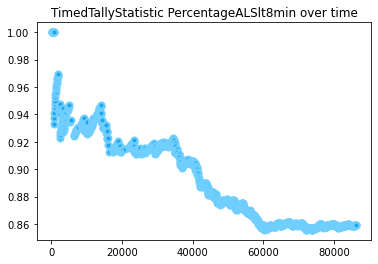

In [517]:
#fig, ax = plt.subplots(1,1, figsize=(15,15))

with open('StatisticsResults/friday_0_coverage_preparedness_Relocate_Workload_0.4_NoUber_0.05.pickle', 'rb') as f:
    statistics = pickle.load(f)

#visualizeSpatialStatistic(ax, nyc_boundaries, statistics[0]['SpatialALSRelocation'].data, nyc_graph_nodes, candidate_points, quantile_clip=1, default=0, method='points', legend=True)
statistics[0]['PercentageALSlt8min'].visualize()
#statistics[0]['TravelTime'].average(),np.std([d[1] for d in statistics[0]['TravelTime'].data])
#plt.hist([d[1] for d in statistics[0]['HSresponseTime'].data], bins=100)
#statistics[1]['Ambulance 1']['Statistics']['State'].visualize()
#statistics[1]['Ambulance 1']['Record']
#statistics[1]['Ambulance 1']['Record'][0][3].node
#print(statistics[0]['SpatialALSRelocation'].data)
#statistics[0]['GAPALSPart1'].visualize()

#A = mapGraphNodesDataToUniformDemand([(d[1], d[2]) for d in statistics[0]['SpatialALSRelocation'].data], demand_points, nyc_graph_nodes, agg='avg', default=0, value_col='value')
#A[~A['value'].isin([0, 1])]
#visualizeStateStatisticData(statistics[0]['AvailableALSVehicles'].data[1:])
#statistics[0]['AvailableALSVehicles'].visualize()

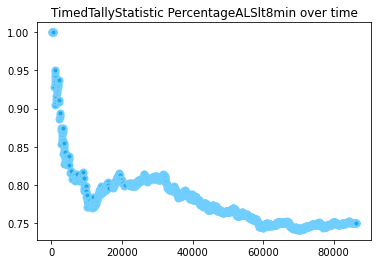

In [519]:
#fig, ax = plt.subplots(1,1, figsize=(15,15))

with open('StatisticsResults/friday_0_survival_preparedness_NoRelocation_Workload_0.4_NoUber_0.05.pickle', 'rb') as f:
    statistics = pickle.load(f)

#visualizeSpatialStatistic(ax, nyc_boundaries, statistics[0]['SpatialALSRelocation'].data, nyc_graph_nodes, candidate_points, quantile_clip=1, default=0, method='points', legend=True)
statistics[0]['PercentageALSlt8min'].visualize()
#statistics[0]['TravelTime'].average(),np.std([d[1] for d in statistics[0]['TravelTime'].data])
#plt.hist([d[1] for d in statistics[0]['HSresponseTime'].data], bins=100)
#statistics[1]['Ambulance 1']['Statistics']['State'].visualize()
#statistics[1]['Ambulance 1']['Record']
#statistics[1]['Ambulance 1']['Record'][0][3].node
#print(statistics[0]['SpatialALSRelocation'].data)
#statistics[0]['GAPALSPart1'].visualize()

#A = mapGraphNodesDataToUniformDemand([(d[1], d[2]) for d in statistics[0]['SpatialALSRelocation'].data], demand_points, nyc_graph_nodes, agg='avg', default=0, value_col='value')
#A[~A['value'].isin([0, 1])]
#visualizeStateStatisticData(statistics[0]['AvailableALSVehicles'].data[1:])
#statistics[0]['AvailableALSVehicles'].visualize()

(array([ 57.,  37.,  49.,  45.,  76.,  92.,  89., 108., 111., 114., 114.,
        119., 101., 117., 128., 109., 108., 110., 106.,  92.,  91.,  88.,
         74., 112.,  97., 104., 116.,  92., 112., 100.,  94., 102.,  85.,
        114.,  87.,  83.,  16.,   5.,  12.,   8.,  13.,   3.,   3.,   3.,
          8.,   3.,   1.,   2.,   3.,   4.,   1.,   1.,   1.,   1.,   0.,
          1.,   2.,   0.,   1.,   1.,   3.,   0.,   1.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   0.        ,   13.41107886,   26.82215771,   40.23323657,
          53.64431543,   67.05539428,   80.46647314,   93.87755199,
         107.28863085,  120.69970971,  134.11078856,  147.52186742,
         160.93294628,  174.34402513,  187.75510399,  201.16618284,
         214.5772617 ,  227.98834056,  241.399

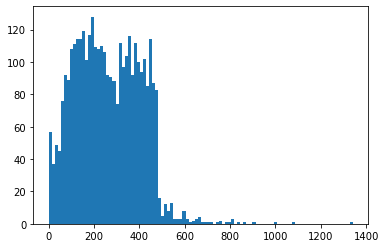

In [489]:
with open('StatisticsResults/Old/friday_0_coverage_preparedness_Relocate_Workload_0.4_NoUber_0.05.pickle', 'rb') as f:
    statistics = pickle.load(f)
plt.hist([d[1] for d in statistics[0]['TravelTime'].data], bins = 100)

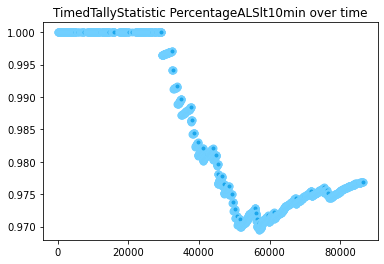

In [298]:
with open('StatisticsResults/friday_0_survival_preparedness_Relocate_Workload_0.4_NoUber.pickle', 'rb') as f:
    statistics = pickle.load(f)
#plt.hist([d[1] for d in statistics[0]['LSresponseTime'].data], bins = 100)
#statistics[1]['Ambulance 4']['Statistics']['State'].visualize()
statistics[0]['PercentageALSlt10min'].visualize()

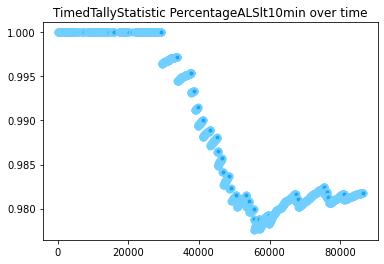

In [130]:
statistics[0]['PercentageALSlt10min'].visualize()

In [37]:
len([(d[1], d[2]) for d in statistics[0]['SpatialHSAverageResponseTime'].data])

1430

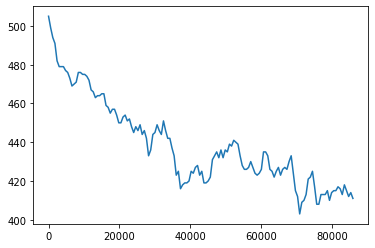

In [5]:
#[d[1] for S in [statistics[0]['OptimizationSizeALS{}'.format(i)] for i in range(1,6)] for d in S.data]
plt.plot([data[0] for data in statistics[0]['OptimizationSizeBLS1'].data],
[sum(d[1] for S in [statistics[0]['OptimizationSizeBLS{}'.format(i)] for i in range(1,6)] for d in S.data if d[0] == data[0]) for data in statistics[0]['OptimizationSizeBLS1'].data])

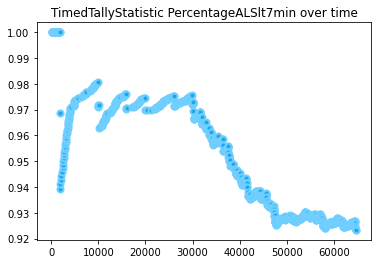

In [112]:
statistics[0]['PercentageALSlt7min'].visualize()

(array([ 42.,  25.,  35.,  38.,  57.,  76.,  71.,  89.,  86.,  95., 102.,
         89., 116., 107.,  94.,  86., 103.,  84.,  81.,  66.,  73.,  66.,
         77.,  71.,  79.,  73.,  82.,  72.,  76.,  72.,  78.,  77.,  69.,
         12.,   4.,   6.,   7.,   1.,   4.,   1.,   3.,   1.,   2.,   3.,
          1.,   1.,   3.,   1.,   2.,   0.,   2.,   1.,   3.,   2.,   0.,
          2.,   0.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([   0.        ,   14.55520018,   29.11040036,   43.66560055,
          58.22080073,   72.77600091,   87.33120109,  101.88640127,
         116.44160145,  130.99680164,  145.55200182,  160.107202  ,
         174.66240218,  189.21760236,  203.77280254,  218.32800273,
         232.88320291,  247.43840309,  261.993

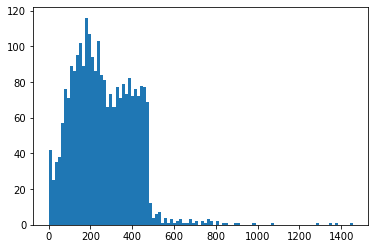

In [115]:
plt.hist([d[1] for d in statistics[0]['TravelTime'].data], bins = 100)

In [86]:
np.array([d[1] for d in statistics[0]['TravelTime'].data]).mean()

291.14943948489235

(array([11.,  9., 19., 18., 27., 43., 70., 69., 56., 60., 76., 73., 74.,
        93., 81., 70., 74., 61., 93., 69., 71., 56., 55., 58., 53., 47.,
        47., 36., 44., 41., 36., 27., 21., 23., 19., 19., 12., 17., 12.,
         8., 12., 11.,  9.,  6.,  4.,  6.,  3.,  5.,  3.,  2.,  2.,  1.,
         1.,  2.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,
         0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,  3.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([  10.34417482,   31.86692052,   53.38966623,   74.91241193,
          96.43515763,  117.95790334,  139.48064904,  161.00339475,
         182.52614045,  204.04888615,  225.57163186,  247.09437756,
         268.61712326,  290.13986897,  311.66261467,  333.18536038,
         354.70810608,  376.23085178,  397.75359749,  419.27634319,
         440.7990889 ,  462.3218346 ,  483.8445803 ,  505.36732601,
         526.89007171,  54

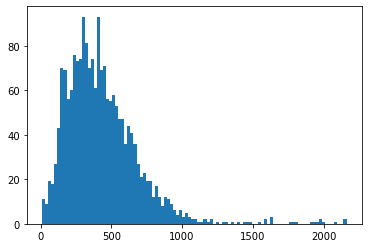

In [72]:
plt.hist([d[1] for d in statistics[0]['ToHospitalTime'].data], bins = 100)

In [87]:
np.array([d[1] for d in statistics[0]['ToHospitalTime'].data]).mean()

432.6503422684321

(array([21., 47., 70., 99., 66., 47., 74., 75., 50.,  8.,  5., 15.,  7.,
         7., 16., 17., 19., 21., 28., 28., 37., 43., 37., 46., 55., 47.,
        59., 58., 68., 65., 65., 61., 65., 53., 61., 59., 60., 54., 43.,
        42., 58., 56., 50., 35., 35., 33., 32., 39., 28., 31., 19., 37.,
        20., 23., 15., 16., 25., 15., 16.,  9.,  8.,  5.,  7., 11.,  4.,
         8.,  4.,  9.,  8., 10.,  3.,  2.,  3.,  1.,  6.,  5.,  3.,  2.,
         3.,  2.,  1.,  1.,  3.,  2.,  1.,  1.,  2.,  0.,  0.,  0.,  2.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([   0.        ,   54.00379827,  108.00759655,  162.01139482,
         216.0151931 ,  270.01899137,  324.02278965,  378.02658792,
         432.0303862 ,  486.03418447,  540.03798275,  594.04178102,
         648.04557929,  702.04937757,  756.05317584,  810.05697412,
         864.06077239,  918.06457067,  972.06836894, 1026.07216722,
        1080.07596549, 1134.07976377, 1188.08356204, 1242.08736031,
        1296.09115859, 135

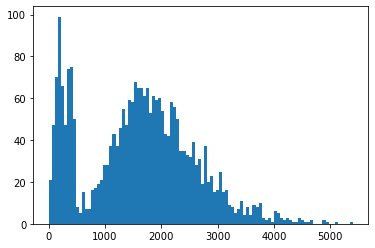

In [116]:
plt.hist([d for d in statistics[0]['EmergenciesTimeInSystem'].data], bins = 100)

(array([ 4.,  8., 11., 14., 16., 33., 40., 37., 41., 43., 40., 47., 49.,
        50., 57., 62., 46., 52., 53., 54., 57., 62., 57., 59., 63., 75.,
        50., 54., 56., 50., 60., 41., 34., 43., 35., 33., 34., 28., 28.,
        26., 25., 19., 17., 18., 18., 16., 18., 16., 13., 11., 11., 10.,
         6.,  9.,  5., 13., 13.,  5.,  7.,  6.,  4.,  9.,  3.,  2.,  1.,
         6.,  2.,  1.,  2.,  1.,  3.,  1.,  1.,  2.,  1.,  0.,  1.,  0.,
         1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  84.97548258,  132.28379012,  179.59209766,  226.90040519,
         274.20871273,  321.51702027,  368.8253278 ,  416.13363534,
         463.44194288,  510.75025042,  558.05855795,  605.36686549,
         652.67517303,  699.98348056,  747.2917881 ,  794.60009564,
         841.90840317,  889.21671071,  936.52501825,  983.83332578,
        1031.14163332, 1078.44994086, 1125.75824839, 1173.06655593,
        1220.37486347, 126

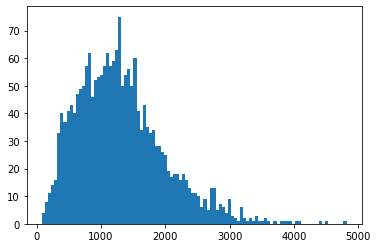

In [75]:
plt.hist([d[1] for d in statistics[0]['LSAttentionTime'].data + statistics[0]['HSAttentionTime'].data if d[1] > 0], bins = 100)

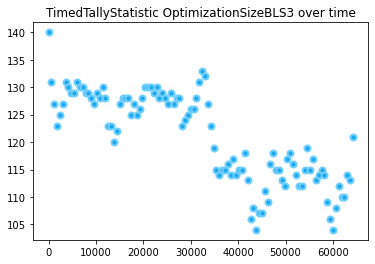

In [117]:
statistics[0]['OptimizationSizeBLS3'].visualize()

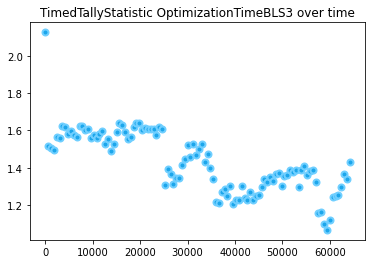

In [118]:
statistics[0]['OptimizationTimeBLS3'].visualize()

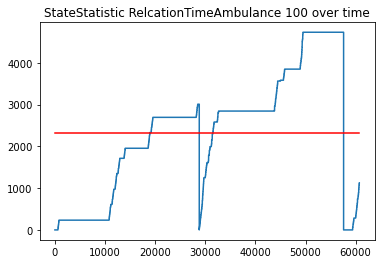

In [120]:
statistics[1]['Ambulance 100']['RelocationTime'].visualize()

In [107]:
statistics[0]['EmergenciesServed'].data

1944

In [337]:
demand_points.loc[0, 'geometry'].coords[0]

(-73.90541332463452, 40.90837854306597)